In [19]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F  # provides functions for activation, loss etc.
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

from src.models.wide_resnet_28_2 import create_model

In [20]:
OUTPUT_DIR = './checkpoints'
DATA_DIR = './data'

### Constructing the Data Loader for FashionMNIST

In [21]:
def print_matrix(matrix):
    s = [[str(round(e, 4)) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))


#================================================= Fashion MNIST =============================================#

class NoisyFashionMNIST(Dataset):
    def __init__(self, dataset, noise_type=None, noise_rate=0.0, transition_matrix=None):
        """
        A wrapper around the FashionMNIST dataset to add optional noise to the labels.

        Args:
            dataset (torch.utils.data.Dataset): The original FashionMNIST dataset.
            noise_type (str, optional): Type of noise to apply. Options: 'symmetric', 'asymmetric'. Default is None.
            noise_rate (float): The proportion of labels to corrupt (between 0 and 1).
            transition_matrix (np.ndarray, optional): A custom transition probability matrix for asymmetric noise.
        """
        self.dataset = dataset
        self.noise_type = noise_type
        self.noise_rate = noise_rate
        self.num_classes = len(DataLoaderFashionMNIST.label_dict)
        self.transition_matrix = transition_matrix
        self._apply_noise()

    def _apply_noise(self):
        """
        Applies the specified noise to the dataset's labels.
        """
        if self.noise_type is None or self.noise_rate <= 0.0:
            # No noise to apply
            self.noisy_labels = self.dataset.targets.clone()  # Keep original labels
            return

        targets = self.dataset.targets.numpy()  # Convert to NumPy for easy manipulation
        n_samples = len(targets)

        if self.noise_type == 'symmetric':
            # Symmetric noise: Replace labels with random labels with uniform probability
            n_noisy = int(self.noise_rate * n_samples)
            noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
            noisy_labels = targets.copy()
            for idx in noisy_indices:
                original_label = targets[idx]
                possible_labels = [label for label in range(self.num_classes) if label != original_label]
                noisy_label = np.random.choice(possible_labels)
                noisy_labels[idx] = noisy_label
            self.noisy_labels = torch.tensor(noisy_labels, dtype=torch.long)

        elif self.noise_type == 'asymmetric':
            if self.transition_matrix is None:
                # Generate a default transition matrix if not provided
                self.transition_matrix = self._generate_default_transition_matrix()

            # Ensure the transition matrix is properly normalized
            assert self.transition_matrix.shape == (self.num_classes, self.num_classes)
            assert np.allclose(self.transition_matrix.sum(axis=1), 1), "Rows must sum to 1"

            noisy_labels = targets.copy()
            for i in range(len(targets)):
                true_label = targets[i]
                noisy_labels[i] = np.random.choice(
                    self.num_classes, p=self.transition_matrix[true_label]
                )
            self.noisy_labels = torch.tensor(noisy_labels, dtype=torch.long)

        else:
            raise ValueError(f"Unknown noise type: {self.noise_type}")

    def _generate_default_transition_matrix(self):
        """
        Generates a default transition matrix for asymmetric noise.
        """
        num_classes = self.num_classes
        matrix = np.eye(num_classes) * (1 - self.noise_rate)  # Start with identity matrix for correct labels

        # Define plausible misclassification probabilities manually
        plausible_transitions = {
            0: [2, 6], # T-shirt -> Pullover, shirt
            1: [6], # Trouser -> Shirt
            2: [0, 6], # Pullover -> T-shirt, shirt
            3: [4],  # Dress -> Coat
            4: [3],  # Coat -> Dress,
            5: [9], # Sandal -> Ankle boot
            6: [0, 2],  # Shirt -> T-shirt, pullover,
            7: [5], # Sneaker -> Sandal
            8: [7], # Bag -> Sneaker
            9: [5] # Ankle Boot -> Sandal 
        }

        # Assign higher probabilities for plausible transitions
        for i in range(num_classes):
            for j in range(num_classes):
                if i != j:  # Off-diagonal
                    
                    if i in plausible_transitions:
                        transition_prob_factor = 0.7
                        if j in plausible_transitions.get(i):
                            matrix[i, j] = self.noise_rate * transition_prob_factor / (len(plausible_transitions.get(i)))
                        else:
                            matrix[i, j] = self.noise_rate * (1-transition_prob_factor) / (num_classes - (1 + len(plausible_transitions.get(i))))

                    else:
                        matrix[i, j] = self.noise_rate / (num_classes - 1)

        # Normalize rows to sum to 1
        #matrix = matrix / matrix.sum(axis=1, keepdims=True)
        print_matrix(matrix)
        return matrix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]  # Get the original image
        label = self.noisy_labels[index]  # Get the noisy label
        return image, label


class DataLoaderFashionMNIST:
    label_dict = [
        "T-shirt/top", # 0
        "Trouser", # 1
        "Pullover", # 2
        "Dress", # 3
        "Coat", # 4
        "Sandal", # 5
        "Shirt", # 6
        "Sneaker", # 7
        "Bag", # 8
        "Ankle boot", # 9
    ]

    # Transformations
    transform_train = transforms.Compose([transforms.ToTensor(),]) # Only one layer (no RGB), already standardized values
    transform_test  = transforms.Compose([transforms.ToTensor(),]) # NOTE! NO AUGMENTATION ALLOWED

    @classmethod
    def get_loaders(
        cls, 
        root='./data/',
        download=True,
        transform_train=transform_train, 
        batch_size=128,
        num_workers=2,
        noise_type=None,
        noise_rate=0.0
        ) -> tuple[torch.utils.data.DataLoader]:
        """
        A getter function that returns both the train and test `torch.utils.data.DataLoader` objects in a tuple. 

        ...

        Args:
            root (str): The path to the directory where the FashionMNIST data is downloaded.
            transform_train (torchvision.transform.Compose): A list of transforms to apply in sequence to the dataset data.
            batch_size (int): The number of samples included in each batch. 
            noise_type (str): Type of noise to apply to train labels. Options: 'symmetric', 'asymmetric'.
            noise_rate (float): The proportion of labels to corrupt (between 0 and 1).

        Returns:
            tuple[torch.utils.data.DataLoader]: A tuple of `DataLoader` objects for the train and test datasets. (train, test)
        """
        assert isinstance(transform_train, transforms.Compose)

        # Original datasets
        dataset_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=download, transform=transform_train)
        dataset_test  = torchvision.datasets.FashionMNIST(root=root, train=False, download=download, transform=cls.transform_test)

        input_shape = dataset_train[0][0].shape

        if noise_type is not None and noise_rate > 0.0:
            dataset_train = NoisyFashionMNIST(dataset=dataset_train, noise_type=noise_type, noise_rate=noise_rate)

        # Data loaders
        dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=batch_size, num_workers=num_workers)
        dataloader_test  = torch.utils.data.DataLoader(dataset=dataset_test, shuffle=False, batch_size=batch_size, num_workers=num_workers)

        return (dataloader_train, dataloader_test, input_shape)

#### Testing the dataloader

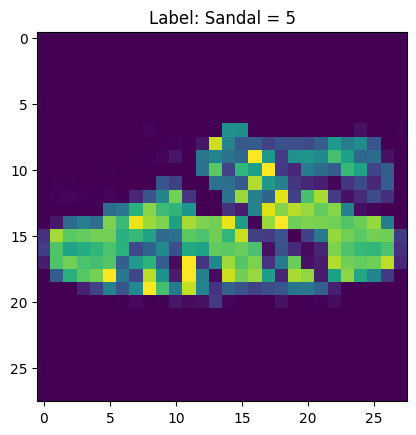

torch.Size([1, 28, 28])

In [22]:
import matplotlib.pyplot as plt
dataloader_train, dataloader_test, input_shape = DataLoaderFashionMNIST.get_loaders(
    root=DATA_DIR,
    download=True,
    batch_size=128,
    num_workers=2,
    noise_type=None, 
    noise_rate=0.0
    )

for batch in dataloader_train:
    images, labels = batch
    # plot first image sample
    plt.imshow(images[0].squeeze())
    plt.title(f'Label: {DataLoaderFashionMNIST.label_dict[labels[0]]} = {labels[0]}')
    plt.show()
    break

input_shape

### Construct the ResNet model architecture

In [23]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, conv_l2=0.0, bn_l2=0.0, version=1):
        super().__init__()
        self.version = version
        self.conv_l2 = conv_l2
        self.bn_l2 = bn_l2

        self.bn1 = nn.BatchNorm2d(in_channels, eps=1e-5, momentum=0.9)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.dropout = nn.Dropout(p=0.3)
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-5, momentum=0.9)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        l2_penalty = 0.0

        if self.version == 2:
            out = F.relu(self.bn1(x))
            shortcut = self.shortcut(out)
        else:
            shortcut = self.shortcut(x)
            out = F.relu(self.bn1(x))

        out = self.conv1(out)
        l2_penalty += self._compute_l2_penalty(self.conv1, self.conv_l2)

        out = self.bn2(out)
        l2_penalty += self._compute_l2_penalty(self.bn2, self.bn_l2)

        out = F.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        l2_penalty += self._compute_l2_penalty(self.conv2, self.conv_l2)

        out += shortcut
        if self.version == 1:
            out = F.relu(out)

        return out, l2_penalty

    def _compute_l2_penalty(self, layer, l2_factor):
        if hasattr(layer, 'weight') and layer.weight.requires_grad and l2_factor > 0.0:
            return l2_factor * layer.weight.pow(2).sum()
        return 0.0


class WideResNet(nn.Module):
    def __init__(self, depth, width_multiplier, num_classes=10, input_shape=(3, 32, 32), version=1, l2=0.0):
        super(WideResNet, self).__init__()
        assert (depth - 4) % 6 == 0, "Depth should be 6n+4."
        num_blocks = (depth - 4) // 6

        self.in_channels = 16
        self.conv1 = nn.Conv2d(input_shape[0], self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.layer1 = self._make_group(16 * width_multiplier, num_blocks, stride=1, version=version, conv_l2=l2, bn_l2=l2)
        self.layer2 = self._make_group(32 * width_multiplier, num_blocks, stride=2, version=version, conv_l2=l2, bn_l2=l2)
        self.layer3 = self._make_group(64 * width_multiplier, num_blocks, stride=2, version=version, conv_l2=l2, bn_l2=l2)

        self.bn = nn.BatchNorm2d(64 * width_multiplier, eps=1e-5, momentum=0.9)
        self.fc = nn.Linear(64 * width_multiplier, num_classes)

    def _make_group(self, out_channels, num_blocks, stride, version, conv_l2, bn_l2):
        layers = []
        layers.append(ResnetBlock(self.in_channels, out_channels, stride, conv_l2, bn_l2, version))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResnetBlock(out_channels, out_channels, stride=1, conv_l2=conv_l2, bn_l2=bn_l2, version=version))
        return nn.Sequential(*layers)

    def forward(self, x):
        total_l2_penalty = 0.0

        x = self.conv1(x)
        x, l2_penalty = self._apply_block(self.layer1, x)
        total_l2_penalty += l2_penalty

        x, l2_penalty = self._apply_block(self.layer2, x)
        total_l2_penalty += l2_penalty

        x, l2_penalty = self._apply_block(self.layer3, x)
        total_l2_penalty += l2_penalty

        x = F.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, 1)  # Global average pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, total_l2_penalty

    def _apply_block(self, block, x):
        total_l2_penalty = 0.0
        for layer in block:
            x, l2_penalty = layer(x)
            total_l2_penalty += l2_penalty
        return x, total_l2_penalty


def create_model(depth=28, width_multiplier=2, num_classes=10, input_shape=(3, 32, 32), version=1, l2=0.0):
    """Create the WideResNet model."""
    return WideResNet(depth, width_multiplier, num_classes, input_shape, version, l2)


def main():
    # Example usage
    model = create_model(depth=28, width_multiplier=2, num_classes=10, version=1, l2=0.0)
    print(model)

In [24]:
main()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): ResnetBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ResnetBlock(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
 

### Construct the training loop

In [25]:
# Configuration
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.1
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cpu')

In [26]:
# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seed for reproducibility
torch.manual_seed(SEED)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        outputs, l2_penalty = model(images)  # Outputs and L2 penalty
        loss = criterion(outputs, labels) + l2_penalty  # Add L2 penalty to loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(loader), accuracy

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs, l2_penalty = model(images)  # Outputs and L2 penalty
            loss = criterion(outputs, labels) + l2_penalty  # Add L2 penalty to loss

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(loader), accuracy


def run():
    # Data loaders
    transform = transforms.Compose([transforms.ToTensor()])

    train_loader, test_loader, input_shape = DataLoaderFashionMNIST.get_loaders(
        root=DATA_DIR,
        download=False,
        transform_train=transform,
        batch_size=128,
        num_workers=2,
        noise_type=None,
        noise_rate=0.0
    )

    # Model, Loss, Optimizer
    model = create_model(depth=28, width_multiplier=2, num_classes=10, input_shape=input_shape, l2=5e-4).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

    # Main Training Loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
        # Save checkpoint
        checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), checkpoint_path)

    print("Training complete!")

### Run the main loop

In [27]:
run()


Epoch 1/10


KeyboardInterrupt: 